In [9]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings("ignore")

In [10]:
re_base_path = "single_objective/linear_regression/scalar_linear_regression/non_skip_introns"
nsga2_base_path = "multi_objective/linear_regression/scalar_linear_regression/non_skip_introns"

n_seeds = 30
feature_size = 4

In [11]:
def get_num_func_evals(file_path):
    with open(file_path, "r") as rf:
        line = rf.readline()
        parts = line.split(',')
        convergence = parts[1]
        convergence = convergence.replace("first time feasible solution:", "").strip()
        return int(convergence)

In [12]:
def get_re_complexity(file_path):
    with open(file_path, "r") as rf:
        line = rf.readline()
        line = rf.readline()
        parts = line.split(',')
        id = parts[0].find("Complexity:")
        num = parts[0][id+12:]
        return int(num)

In [13]:
def get_error(file_path):
    with open(file_path, "r") as rf:
        line = rf.readline()
        line = rf.readline()
        parts = line.split(',')
        error = parts[1]
        error = error.replace("Training Error:", "")
        error = error.strip()
        num = float(error)
        return num

In [14]:
az_results = {"complexity": [], "accuracy": [], "convergence": []}
moaz_mut_results = {"complexity": [], "accuracy": [], "convergence": []}
moaz_cross_mut_results = {"complexity": [], "accuracy": [], "convergence": []}

## collect the convergence speeds

In [15]:
for seed in range(1, n_seeds+1):
    az_results["convergence"].append(get_num_func_evals(f"{re_base_path}/features_{feature_size}/seed_{seed}/final_program_descriptions.txt"))
    moaz_mut_results["convergence"].append(get_num_func_evals(f"{nsga2_base_path}/features_{feature_size}/seed_{seed}/mut/final_programs_descriptions.txt"))
    moaz_cross_mut_results["convergence"].append(get_num_func_evals(f"{nsga2_base_path}/features_{feature_size}/seed_{seed}/cross_mut/final_programs_descriptions.txt"))

## collect the complexities

In [16]:
for seed in range(1, n_seeds+1):
    az_results["complexity"].append(get_re_complexity(f"{re_base_path}/features_{feature_size}/seed_{seed}/final_program_descriptions.txt"))
    moaz_cross_mut_results["complexity"].append(list(pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{seed}/cross_mut/final_pf_train.txt", names=["error", "complexity"])["complexity"]))
    moaz_mut_results["complexity"].append(list(pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{seed}/mut/final_pf_train.txt", names=["error", "complexity"])["complexity"]))

## collect the accuracies

In [17]:
for seed in range(1, n_seeds+1):
    az_results["accuracy"].append(1 - get_error(f"{re_base_path}/features_{feature_size}/seed_{seed}/final_program_descriptions.txt"))
    moaz_cross_mut_results["accuracy"].append(list(1-pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{seed}/cross_mut/final_pf_train.txt", names=["error", "complexity"])["error"]))
    moaz_mut_results["complexity"].append(list(pd.read_csv(f"{nsga2_base_path}/features_4/seed_{seed}/mut/final_pf_train.txt", names=["error", "complexity"])["complexity"]))

In [18]:
results_df = pd.DataFrame(columns=["criterion", "az", "moaz"])

## Analysis of the accuracy

In [19]:
az_mask = np.array(az_results["accuracy"]) > 0.9
az_convergence_frac = sum(np.array(az_results["accuracy"]) > 0.9)/n_seeds * 100
moaz_convergence_sum = 0
for i in range(n_seeds):
    moaz_convergence_sum += int(sum(np.array(moaz_cross_mut_results["accuracy"][i]) > 0.9) > 0)
moaz_convergence_frac = moaz_convergence_sum/n_seeds * 100

print(az_convergence_frac)
print(moaz_convergence_frac)
results_df = results_df.append({"criterion": "convergence fraction", "az": az_convergence_frac, "moaz": moaz_convergence_frac}, ignore_index=True)
results_df

66.66666666666666
100.0


,criterion,az,moaz
0,convergence fraction,66.666667,100.0


## Analysis of convergence

In [20]:
az_results_convergence = np.array(az_results["convergence"])
az_results_convergence_median = np.median(az_results_convergence[az_results_convergence > 0])
az_results_convergence_std = np.std(az_results_convergence[az_results_convergence > 0])
print(az_results_convergence_median)
print(az_results_convergence_std)

moaz_results_convergence = np.array(moaz_cross_mut_results["convergence"])
moaz_results_convergence_median = np.median(moaz_results_convergence[moaz_results_convergence > 0])
moaz_results_convergence_std = np.std(moaz_results_convergence[moaz_results_convergence > 0])
print(moaz_results_convergence_median)
print(moaz_results_convergence_std)

results_df = results_df.append({"criterion": "median convergence length", "az": f"{np.format_float_scientific(az_results_convergence_median)} ({np.format_float_scientific(az_results_convergence_std)})", "moaz": f"{np.format_float_scientific(moaz_results_convergence_median)} ({np.format_float_scientific(moaz_results_convergence_std)})"}, ignore_index=True)
results_df

893431.5
694679.845825147
165792.0
180339.696828205


,criterion,az,moaz
0,convergence fraction,66.666667,100.0
1,median convergence length,8.934315e+05 (6.94679845825147e+05),1.65792e+05 (1.80339696828205e+05)


## Analysis of complexity

In [21]:
az_complexity = np.array(az_results["complexity"])[az_mask]
az_complexity_median = np.median(az_complexity)
az_complexity_std = np.std(az_complexity)
print(az_complexity_median)
print(az_complexity_std)

moaz_complexity = []
for i in range(n_seeds):
    cur_complexity = np.array(moaz_cross_mut_results["complexity"][i])
    cur_accuracy = np.array(moaz_cross_mut_results["accuracy"][i])
    cur_mask = cur_accuracy > 0.9
    cur_complexity = cur_complexity[cur_mask]
    min_complexity = min(cur_complexity)
    moaz_complexity.append(min_complexity)

moaz_complexity_median = np.median(moaz_complexity)
moaz_complexity_std = np.std(moaz_complexity)
print(moaz_complexity_median)
print(moaz_complexity_std)

results_df = results_df.append({"criterion": "complexity", "az": f"{az_complexity_median} ({az_complexity_std})", "moaz": f"{moaz_complexity_median} ({moaz_complexity_std})"}, ignore_index=True)

79.5
16.809521111560557
30.0
2.167692065051881


In [22]:
results_df

,criterion,az,moaz
0,convergence fraction,66.666667,100.0
1,median convergence length,8.934315e+05 (6.94679845825147e+05),1.65792e+05 (1.80339696828205e+05)
2,complexity,79.5 (16.809521111560557),30.0 (2.167692065051881)


## Analysis of the pareto front

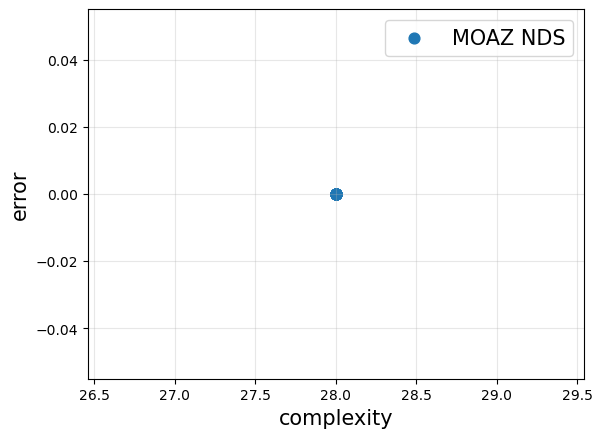

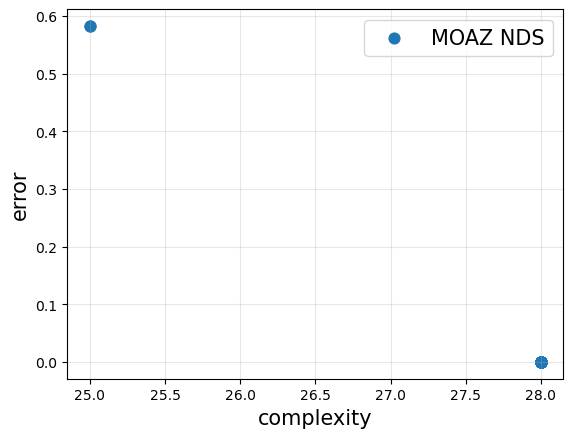

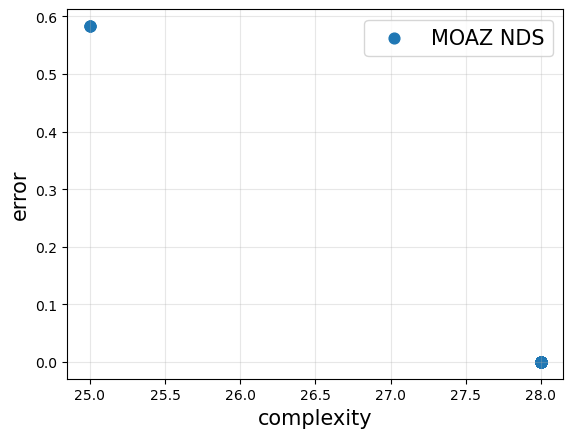

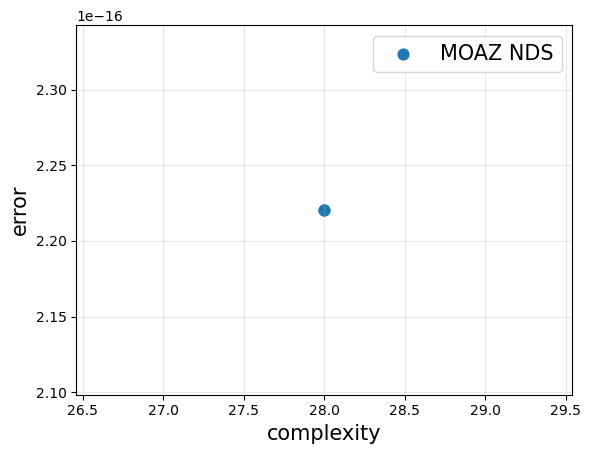

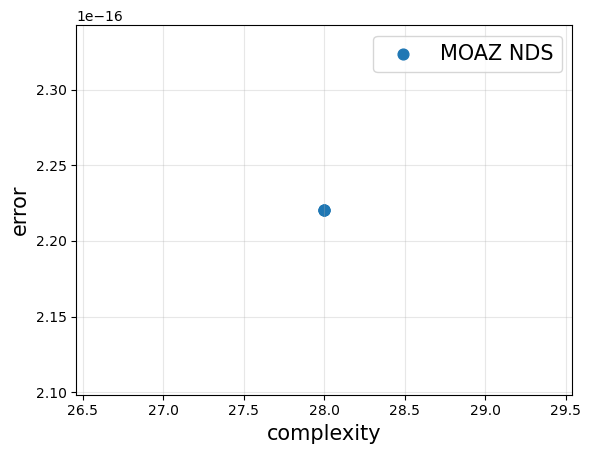

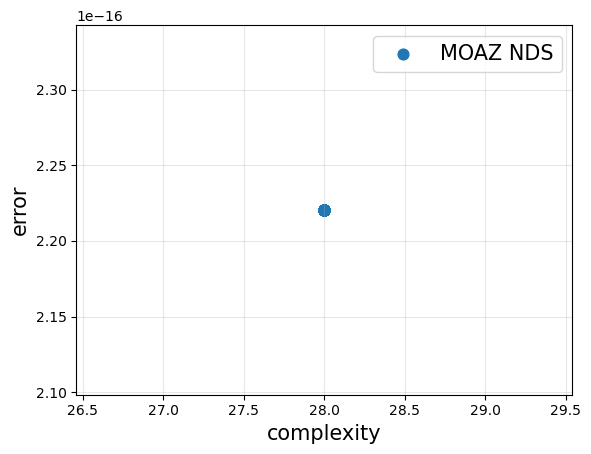

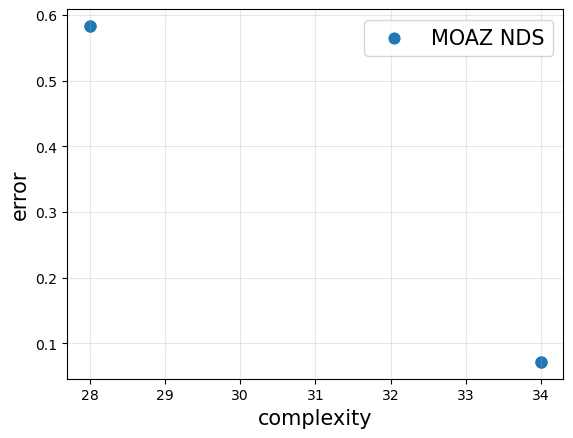

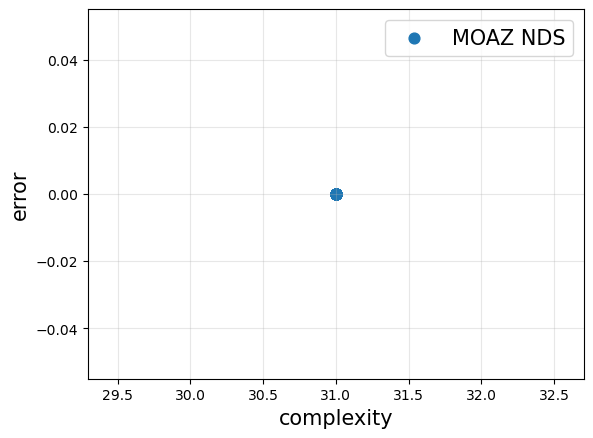

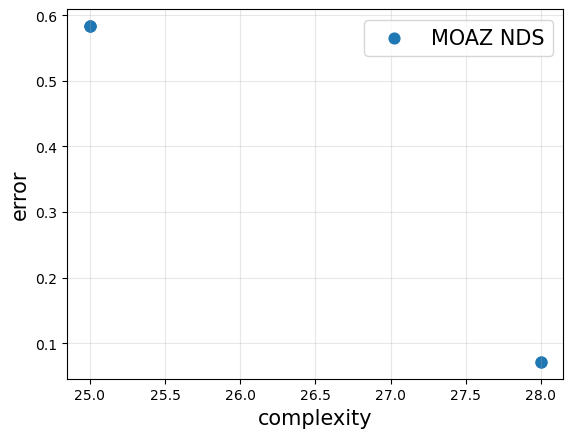

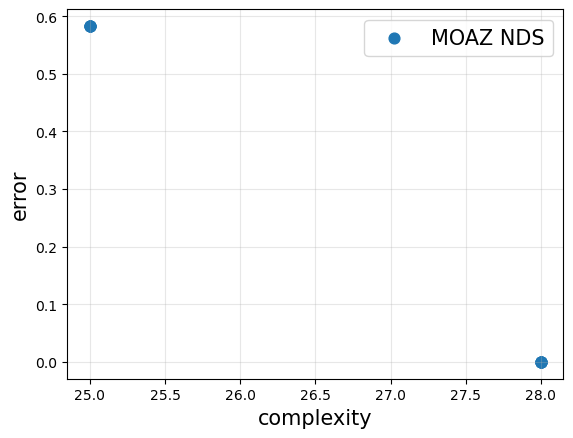

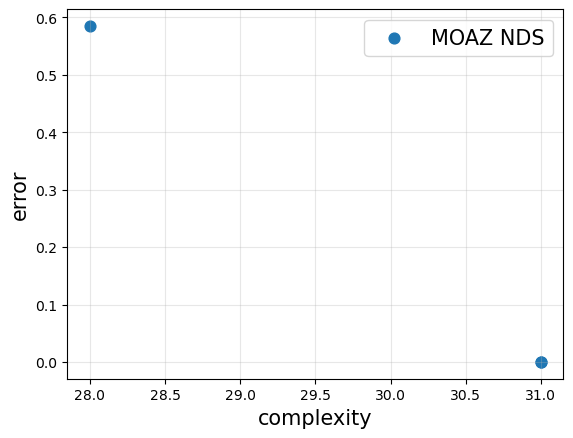

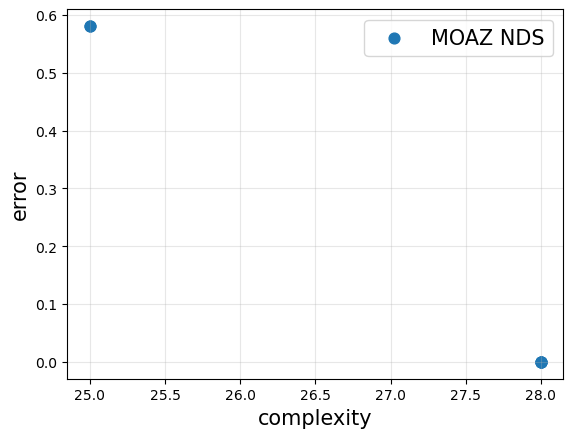

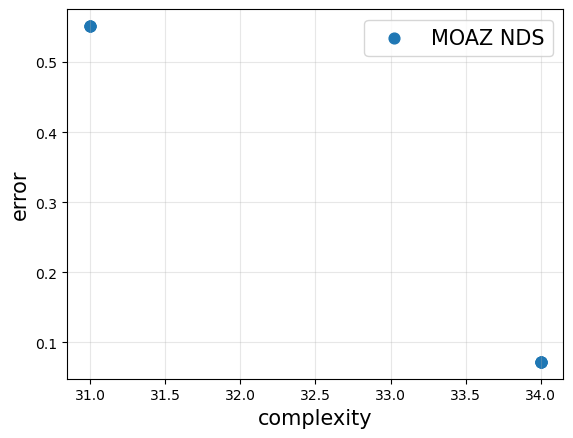

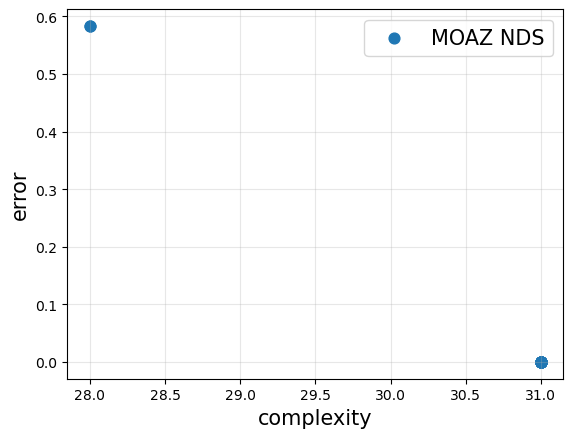

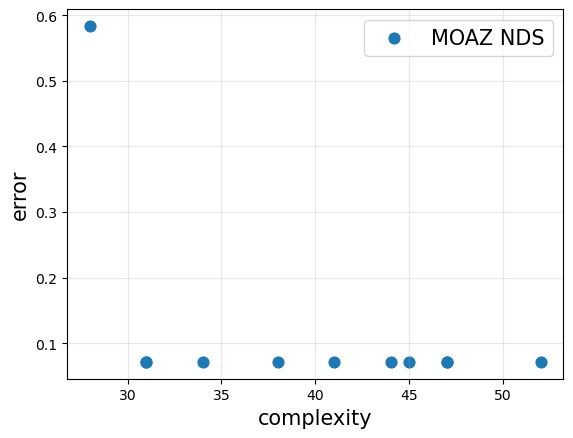

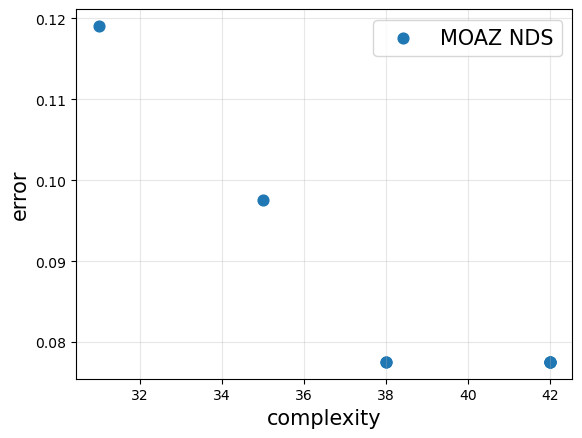

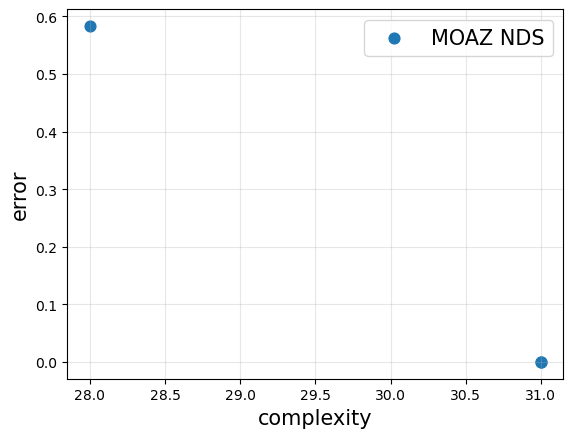

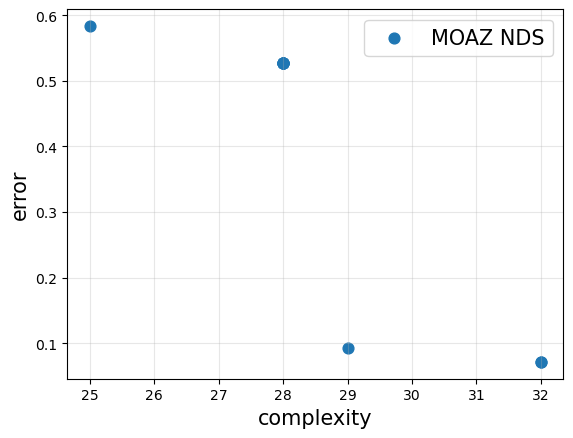

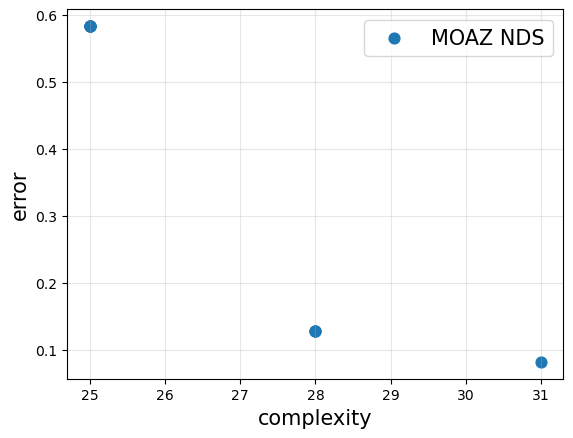

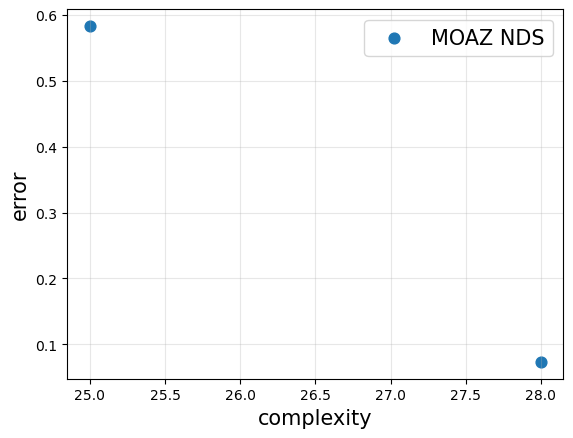

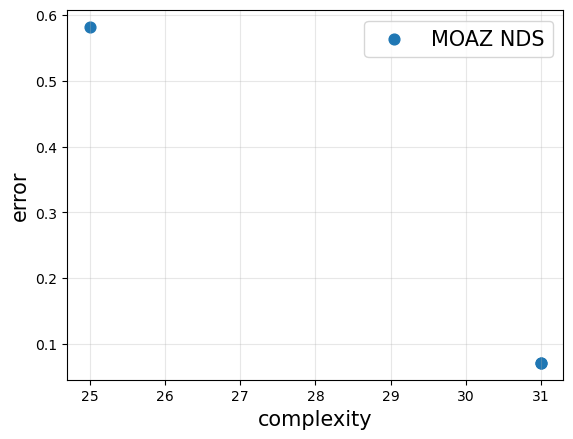

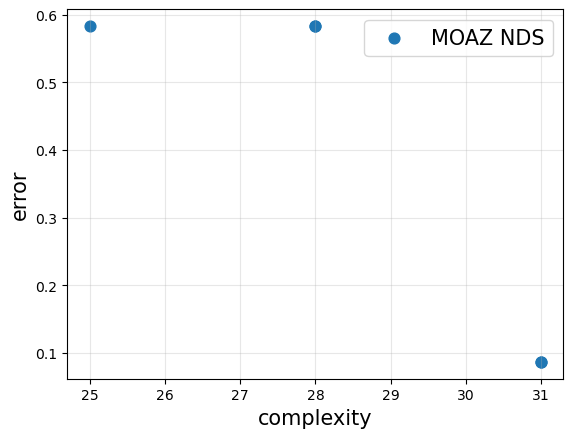

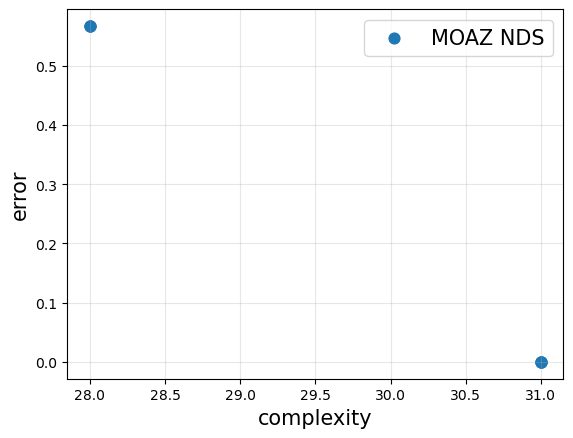

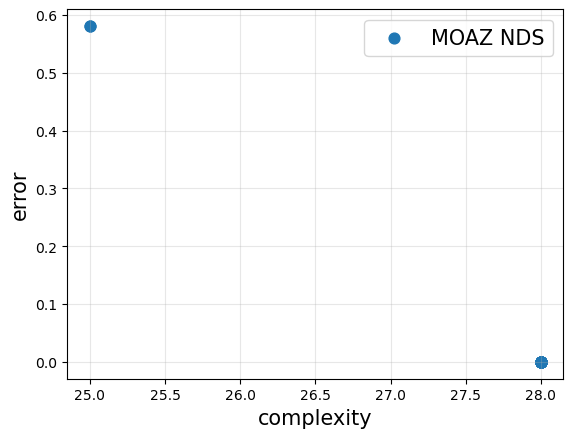

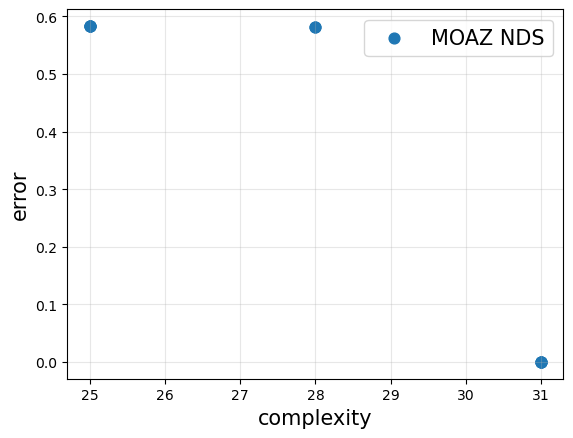

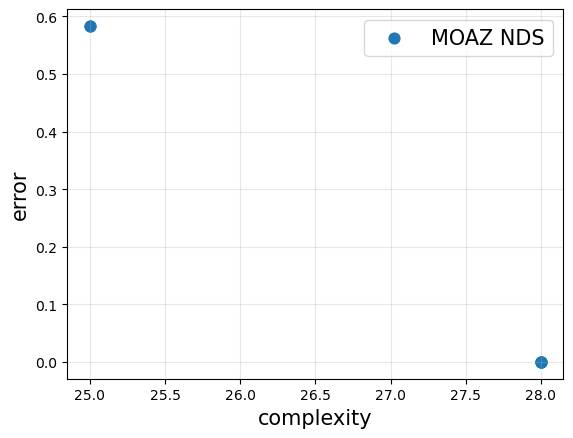

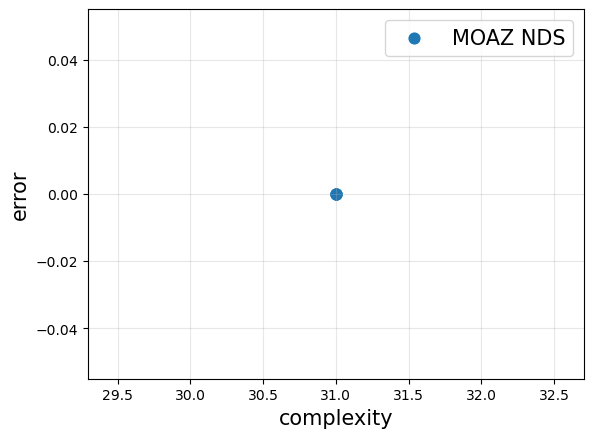

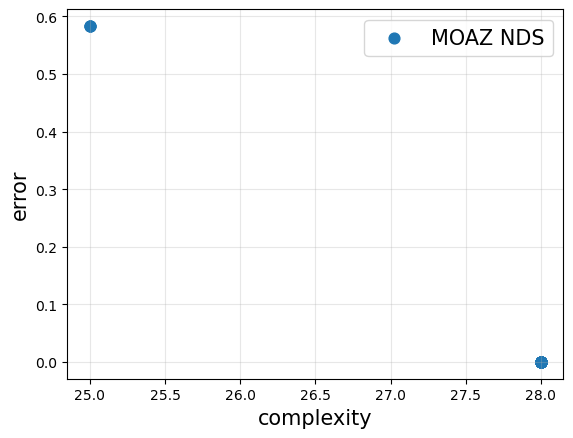

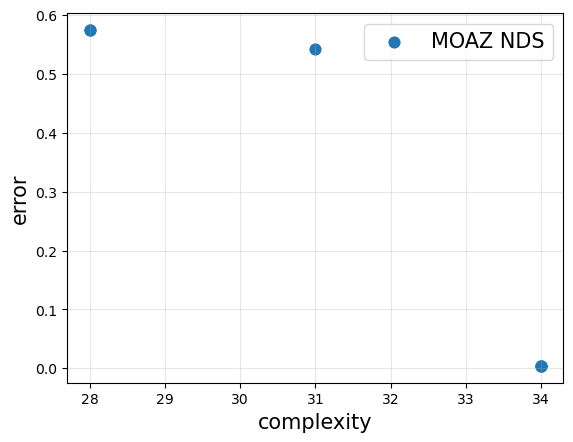

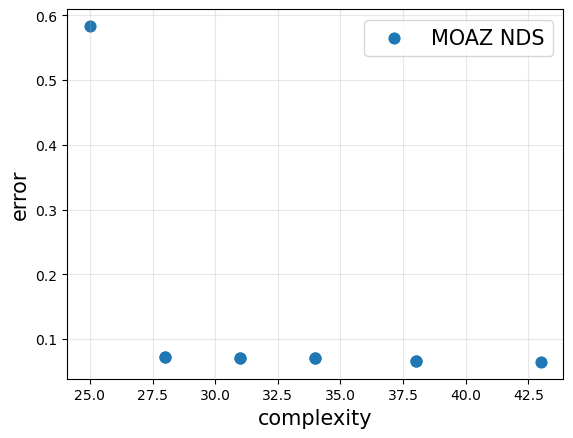

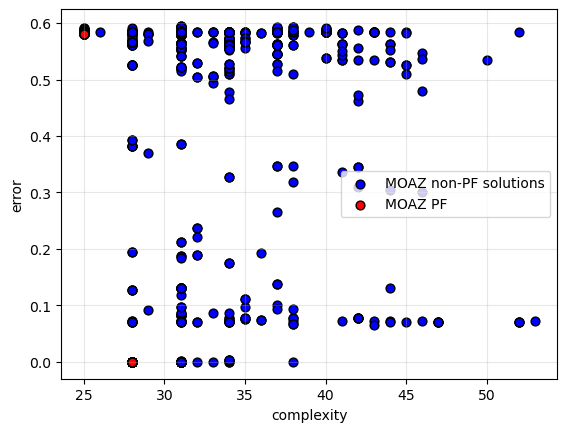

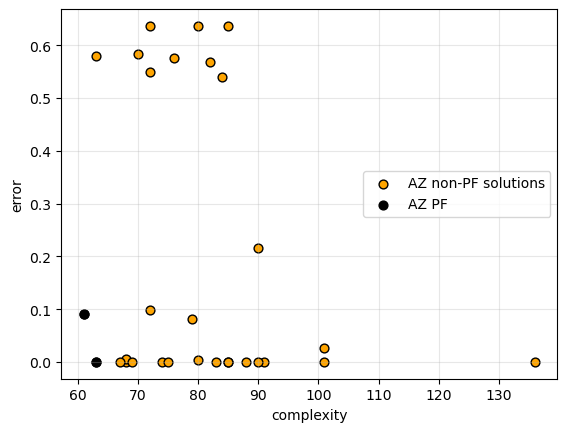

In [23]:
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
nds = NonDominatedSorting()

moaz_complexities = []
moaz_accuracies = []
seeds = []

swarm_plot_df = pd.DataFrame(columns=["framework", "error", "complexity"])
for i in range(n_seeds):
    cur_complexity = moaz_cross_mut_results["complexity"][i]
    cur_accuracy = moaz_cross_mut_results["accuracy"][i]
    moaz_complexities += moaz_cross_mut_results["complexity"][i]
    moaz_accuracies += moaz_cross_mut_results["accuracy"][i]
    F = np.column_stack((cur_complexity, 1 - np.array(cur_accuracy)))
    I = nds.do(F)
    nds_F = F[I[0], :]
    fig, ax = plt.subplots()
    # ax.set_title(f"seed: {i+1}")
    ax.scatter(nds_F[:, 0], nds_F[:, 1], s=60, label="MOAZ NDS")
    ax.set_xlabel("complexity", fontsize=15)
    ax.set_ylabel("error", fontsize=15)
    ax.legend(loc="upper right", fontsize=15)
    ax.grid(alpha=0.3)
    fig.savefig(f"multi_objective/seed_{i+1}_pf.pdf", format="pdf")

    for j in range(len(cur_complexity)):
        seeds += [(i, j)]

moaz_complexities = np.array(moaz_complexities)
moaz_accuracies = np.array(moaz_accuracies)
moaz_errors = 1 - moaz_accuracies
seeds = np.array(seeds)

for i in range(len(moaz_complexities)):
    swarm_plot_df = swarm_plot_df.append({"framework": "MOAZ", "error": moaz_errors[i], "complexity": moaz_complexities[i]}, ignore_index=True)

F = np.column_stack((moaz_complexities, moaz_errors))
I = nds.do(F)
nds_F = F[I[0], :]
seeds = seeds[I[0]]

fig, ax = plt.subplots()
plt.scatter(F[:, 0], F[:, 1], color="blue", edgecolors="black", s=40, label="MOAZ non-PF solutions")
plt.scatter(nds_F[:, 0], nds_F[:, 1], color="red", s=40, edgecolors="black", label="MOAZ PF")
ax.set_xlabel("complexity")
ax.set_ylabel("error")
ax.grid(alpha=0.3)
ax.legend(loc="center right")
fig.savefig("images/moaz_pf.pdf", format="pdf")

az_complexities = np.array(az_results["complexity"])
az_errors = 1 - np.array(az_results["accuracy"])

for i in range(len(az_errors)):
    swarm_plot_df = swarm_plot_df.append({"framework": "AZ", "error": az_errors[i], "complexity": az_complexities[i]}, ignore_index=True)

F = np.column_stack((az_complexities, az_errors))
I = nds.do(F)
nds_F = F[I[0], :]

fig, ax = plt.subplots()
plt.scatter(F[:, 0], F[:, 1], color="orange", edgecolors="black", s=40, label="AZ non-PF solutions")
plt.scatter(nds_F[:, 0], nds_F[:, 1], color="black", s=40, edgecolors="black", label="AZ PF")
ax.legend(loc="center right")
ax.set_xlabel("complexity")
ax.set_ylabel("error")
ax.grid(alpha=0.3)
fig.savefig("images/az_pf.pdf", format="pdf")

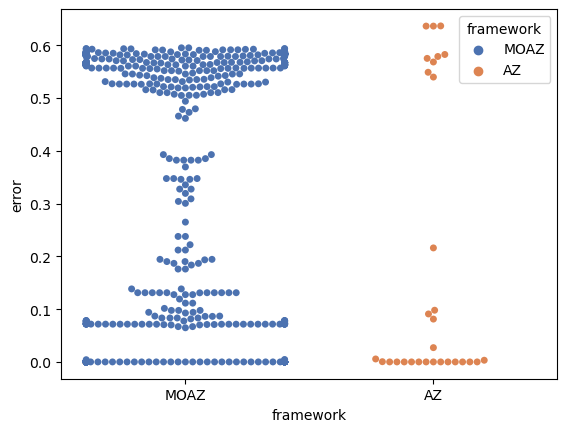

In [24]:
import seaborn as sns
sns.swarmplot(data=swarm_plot_df, x="framework", y="error", hue="framework", palette="deep")
plt.savefig("images/swarm_plot_error.pdf", format="pdf")

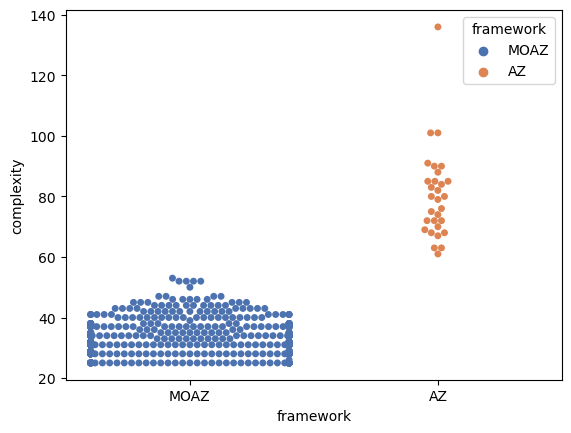

In [25]:
sns.swarmplot(data=swarm_plot_df, x="framework", y="complexity", hue="framework", palette="deep")
plt.savefig("images/swarm_plot_complexity.pdf", format="pdf")

## MOAZ mut and crossover exp

In [26]:
moaz_mut_results["hv"] = []
moaz_cross_mut_results["hv"] = []

for i in range(n_seeds):
    moaz_mut_results["hv"].append(pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{i+1}/mut/hv_exp_mut.txt", sep=",").iloc[-1, 1])
    moaz_cross_mut_results["hv"].append(pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{i+1}/cross_mut/hv_exp_cross_mut.txt", sep=",").iloc[-1, 1])

moaz_mut_hv = np.array(moaz_mut_results["hv"])
moaz_cross_mut_hv = np.array(moaz_cross_mut_results["hv"])

np.mean(moaz_cross_mut_hv)
moaz_mut_results["hv"] = []
moaz_cross_mut_results["hv"] = []

for i in range(n_seeds):
    moaz_mut_results["hv"].append(
        pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{i + 1}/mut/hv_exp_mut.txt", sep=",").iloc[-1, 1])
    moaz_cross_mut_results["hv"].append(
        pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{i + 1}/cross_mut/hv_exp_cross_mut.txt",
                    sep=",").iloc[-1, 1])

moaz_mut_hv = np.array(moaz_mut_results["hv"])
moaz_cross_mut_hv = np.array(moaz_cross_mut_results["hv"])

print(np.mean(moaz_cross_mut_hv))
print(np.mean(moaz_mut_hv))

47.574896666666675
45.807719999999996


## az hv

In [27]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

def calculate_hv(F):
    nds = NonDominatedSorting()
    I = nds.do(F)
    hv = HV(ref_point=(101, 0.7))
    return hv.do(F[I[0]])

def hv_progress_re(file_path):
    az_hv_df = pd.read_csv(file_path, names=["complexity", "error"])

    F = None
    hv_res = pd.DataFrame(columns=["func_evals", "hv"])
    cur_evals = 0
    for index, row in az_hv_df.iterrows():
        if np.isnan(row["error"]):
            if F is not None:
                F = np.array(F)
                cur_hv = calculate_hv(F)
                hv_res = hv_res.append({"func_evals": cur_evals, "hv": cur_hv}, ignore_index=True)

            F = []
            cur_evals = row["complexity"]
        else:
            F.append([row["complexity"], row["error"]])

    hv_res.to_csv(f"{file_path.replace('hv_exp.txt', 'hv_exp_final.txt')}", index=None)

for i in range(n_seeds):
    hv_progress_re(f"{re_base_path}/features_{feature_size}/seed_{i+1}/hv_exp.txt")


In [28]:
az_results["hv"] = []
moaz_cross_mut_results["hv"] = []

for i in range(n_seeds):
    az_results["hv"].append(pd.read_csv(f"{re_base_path}/features_{feature_size}/seed_{i+1}/hv_exp_final.txt", sep=",").to_numpy())
    moaz_cross_mut_results["hv"].append(pd.read_csv(f"{nsga2_base_path}/features_{feature_size}/seed_{i+1}/cross_mut/hv_exp_cross_mut.txt", sep=",").to_numpy())

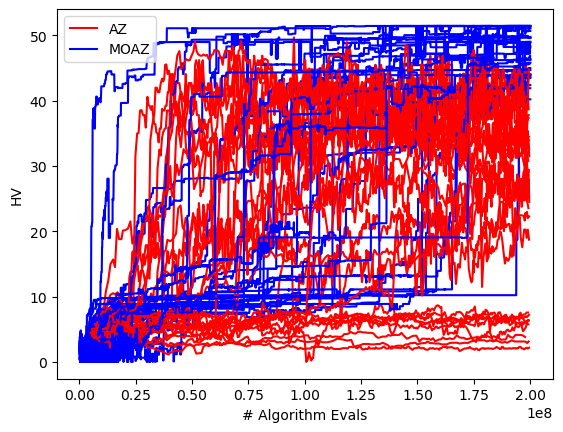

In [29]:
fig, ax = plt.subplots()
for i in range(n_seeds):
    if i > 0:
        az_label = None
        moaz_label = None
    else:
        az_label = "AZ"
        moaz_label = "MOAZ"
    ax.plot(az_results["hv"][i][:, 0], az_results["hv"][i][:, 1], color="red", label=az_label)
    ax.plot(moaz_cross_mut_results["hv"][i][:, 0], moaz_cross_mut_results["hv"][i][:, 1], color="blue", label=moaz_label)

ax.legend(loc="upper left")
ax.set_xlabel("# Algorithm Evals")
ax.set_ylabel("HV")
fig.savefig("hv_progress.png")

In [ ]:
    from sklearn.linear_model import LinearRegression
import copy

cur_moaz_arr = moaz_cross_mut_results["hv"][0]
cur_az_arr = az_results["hv"][0]
for i in range(n_seeds):
    cur_moaz_arr = np.append(cur_moaz_arr, moaz_cross_mut_results["hv"][i], axis=0)
    cur_az_arr = np.append(cur_az_arr, az_results["hv"][i], axis=0)

num=cur_moaz_arr.shape[0]
degree = 5
idx = np.argsort(cur_moaz_arr[:, 0])
cur_moaz_arr = cur_moaz_arr[idx, :]
x = cur_moaz_arr[:num, 0]
y = cur_moaz_arr[:num, 1].reshape(-1, 1)

max_x = max(x)
test_x = np.arange(max_x)

X = copy.deepcopy(x)
test_X = copy.deepcopy(test_x)

for d in range(2, degree+1):
    X = np.column_stack((X, x**d))
    test_X = np.column_stack((test_X, test_x**d))

reg = LinearRegression().fit(X, y)
preds_moaz = reg.predict(test_X)

idx = np.argsort(cur_az_arr[:, 0])
cur_az_arr = cur_az_arr[idx, :]
x = cur_az_arr[:num, 0]
y = cur_az_arr[:num, 1].reshape(-1, 1)

X = copy.deepcopy(x)
for d in range(2, degree+1):
    X = np.column_stack((X, x**d))

reg = LinearRegression().fit(X, y)
preds_az = reg.predict(test_X)


fig, ax = plt.subplots()
ax.plot(test_X, preds_moaz)
ax.plot(test_X, preds_az)

In [ ]:
plt.scatter(x[:, 0], y)

## Scaling experiment

In [ ]:
az_convergence = []
moaz_convergence = []

feature_list = [4, 8, 16, 32]
for num_features in feature_list:
    count_az = 0
    count_moaz = 0
    for seed in range(n_seeds):
        convergence_length_az = get_num_func_evals(f"{re_base_path}/features_{num_features}/seed_{seed+1}/final_program_descriptions.txt")
        convergence_length_moaz = get_num_func_evals(f"{nsga2_base_path}/features_{num_features}/seed_{seed+1}/cross_mut/final_programs_descriptions.txt")
        # print(f"{nsga2_base_path}/features_{num_features}/seed_{seed+1}/cross_mut/final_programs_descriptions.txt")
        # print(f"features: {num_features}, seed: {seed+1}, AZ: {convergence_length_az}, MOAZ: {convergence_length_moaz}")
        if convergence_length_az != -1:
            count_az += 1
        if convergence_length_moaz != -1:
            count_moaz += 1

    az_convergence.append(count_az/n_seeds * 100)
    moaz_convergence.append(count_moaz/n_seeds * 100)
    print(f"features: {num_features}, AZ: {count_az}, MOAZ: {count_moaz}")

fig, ax = plt.subplots()
ax.plot(np.arange(len(feature_list)), az_convergence, color="red")
ax.plot(np.arange(len(feature_list)), moaz_convergence, color="blue")
ax.scatter(np.arange(len(feature_list)), az_convergence, s=60, color="red", edgecolors="black", label="AZ")
ax.scatter(np.arange(len(feature_list)), moaz_convergence, s=60, color="blue", edgecolors="black", label="MOAZ")
ax.set_xticks(np.arange(len(feature_list)))
ax.set_xticklabels([str(feature) for feature in feature_list])
ax.legend(loc="upper right")
ax.set_xlabel("# features")
ax.set_ylabel("convergence (in %)")
ax.grid(alpha=0.3)
fig.savefig("images/scaling_convergence.pdf", format="pdf")

    ## convergence comparison

In [ ]:
list_az_log_vals = np.log(az_results["convergence"])
list_moaz_cross_mut_log_vals = np.log(moaz_cross_mut_results["convergence"])

fig, ax = plt.subplots()
for seed in range(1, n_seeds+1):
    cur_az_val = az_results["convergence"][seed-1]
    cur_moaz_val = moaz_cross_mut_results["convergence"][seed-1]

    if cur_az_val != -1:
        if cur_az_val < cur_moaz_val:
            color = "red"
        else:
            color = "blue"
        ax.scatter(np.log(cur_az_val), np.log(cur_moaz_val), color=color, s=90, alpha=0.8, edgecolors="black")
ax.set_xlim([8, 17])
ax.set_ylim([9, 14])
ax.axline([0, 0], [1, 1], color="black", label=f"45$^\circ$ line")
ax.set_xlabel("AZ", fontsize= 12)
ax.set_ylabel("MOAZ", fontsize= 12)
ax.legend(loc="upper left", fontsize= 15)
fig.savefig("images/convergence_comparison.png")
fig.show()

In [ ]:
swarm_plot_convergence = pd.DataFrame()
list_convergence = moaz_cross_mut_results["convergence"] + az_results["convergence"]
list_convergence = np.array(list_convergence, dtype=np.float)
list_convergence[list_convergence == -1] = np.inf
# list_convergence = np.log(list_convergence)
list_frameworks = ["MOAZ"] * len(moaz_cross_mut_results["convergence"]) + ["AZ"] * len(az_results["convergence"])
swarm_plot_convergence["framework"] = list_frameworks
swarm_plot_convergence["convergence length"] = list_convergence
swarm_plot_convergence

In [ ]:
sns.swarmplot(data=swarm_plot_convergence, x="framework", y="convergence length", hue="framework", palette="deep")
plt.savefig("images/swarm_plot_convergence.pdf", format="pdf")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.arange(1, n_seeds+1), list_re_vals, label="AMZ", color="blue")
ax.scatter(np.arange(1, n_seeds+1), list_nsga2_cross_mut_vals, label="MOAZ", color="orange")
ax.legend(loc="upper right")
ax.set_xticks(np.arange(1, n_seeds+1), np.arange(1, n_seeds+1))
ax.set_xlabel("seed")
ax.set_ylabel("# num_evals")
fig.show()

In [ ]:
print(f"nsga2 cross mut median: {np.median(list_nsga2_cross_mut_vals)}")
print(f"re median: {np.median(list_re_vals)}")
print(f"nsga2 cross mut std: {np.std(list_nsga2_cross_mut_vals)}")
print(f"re std: {np.std(list_re_vals)}")

In [ ]:
fig, ax = plt.subplots()
list_re_log_vals = np.log(np.array(list_re_vals))
# list_nsga2_mut_log_vals = np.log(np.array(list_nsga2_mut_vals))
list_nsga2_cross_mut_log_vals = np.log(np.array(list_nsga2_cross_mut_vals))
for seed in range(1, n_seeds+1):
    if list_re_log_vals[seed-1] < list_nsga2_cross_mut_log_vals[seed-1]:
        color = "red"
    else:
        color = "blue"
    ax.scatter(list_re_log_vals[seed-1], list_nsga2_cross_mut_log_vals[seed-1], color=color, s=90, alpha=0.8, edgecolors="black")
ax.set_xlim([8, 17])
ax.set_ylim([9, 14])
ax.axline([0, 0], [1, 1], color="black", label=f"45$^\circ$ line")
ax.set_xlabel("AZ", fontsize= 12)
ax.set_ylabel("MOAZ", fontsize= 12)
ax.legend(loc="upper left", fontsize= 15)
fig.savefig("eval_comp_az_moaz.jpg", dpi=400)
fig.show()

# Hypervolume calculation

In [ ]:
list_hv_mut = []
list_hv_cross_mut = []
fig, ax = plt.subplots()
for seed in range(1, n_seeds+1):
    path_cross_mut = f"{nsga2_base_path}/seed_{seed}/cross_mut/hv_exp_cross_mut.txt"
    path_mut = f"{nsga2_base_path}/seed_{seed}/mut/hv_exp_mut.txt"
    hv_mut_df = pd.read_csv(path_mut, names=["eval", "hv"])
    hv_cross_mut_df = pd.read_csv(path_cross_mut, names=["eval", "hv"])
    list_hv_cross_mut.append(hv_cross_mut_df["hv"].iloc[-1])
    list_hv_mut.append(hv_mut_df["hv"].iloc[-1])
    ax.plot(hv_mut_df.iloc[:, 0], hv_mut_df.iloc[:, 1], color="red")
    ax.plot(hv_cross_mut_df.iloc[:, 0], hv_cross_mut_df.iloc[:, 1], color="BLUE")
    fig.show()

print(f"median cross_mut: {np.median(list_hv_cross_mut)}")
print(f"median mut: {np.median(list_hv_mut)}")
print(f"std cross_mut: {np.std(list_hv_cross_mut)}")
print(f"std mut: {np.std(list_hv_mut)}")

## AMZ result collection

In [ ]:
## get the complexity
list_re_complexity_vals = []
list_re_func_vals = []

for seed in range(1, n_seeds+1):
    list_re_complexity_vals.append(get_re_complexity(f"{re_base_path}/seed_{seed}/final_program_descriptions.txt"))
    list_re_func_vals.append(get_num_func_evals(f"{re_base_path}/seed_{seed}/final_program_descriptions.txt"))

re_eval_df = pd.DataFrame()
re_eval_df["seed"] = list(np.arange(1, n_seeds+1))
re_eval_df["complexity"] = list_re_complexity_vals
re_eval_df["func_evals"] = list_re_func_vals

print(re_eval_df.median())
print(re_eval_df.std())

re_eval_df.to_csv("amz_results.csv", index=False)

## MOAZ result collection

In [ ]:
nsga2_eval_df = None
for seed in range(1, n_seeds+1):
    if nsga2_eval_df is None:
        nsga2_eval_df = pd.read_csv(f"{nsga2_base_path}/features_4/seed_{seed}/cross_mut/final_pf_train.txt", names=["error", "complexity"])
        nsga2_eval_df["seed"] = seed
        nsga2_eval_df["id"] = np.arange(nsga2_eval_df.shape[0])
    else:
        cur_df = pd.read_csv(f"{nsga2_base_path}/features_4/seed_{seed}/cross_mut/final_pf_train.txt", names=["error", "complexity"])
        cur_df["seed"] = seed
        cur_df["id"] = np.arange(cur_df.shape[0])
        nsga2_eval_df = pd.concat((nsga2_eval_df, cur_df))

nsga2_eval_df.to_csv("moaz_results.csv", index=False)

In [ ]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
nds = NonDominatedSorting()

# F = nsga2_eval_df[["error", "complexity"]].to_numpy()
F = nsga2_eval_df[nsga2_eval_df["seed"] == 13][["error", "complexity"]].to_numpy()
fronts = nds.do(F)
F_pf = F[fronts[0]]
print(F_pf)
# F_pf[:, 0] = (F_pf[:, 0] - F_pf[:, 0].min())/(F_pf[:, 0].max() - F_pf[:, 0].min())
# F_pf[:, 1] = (F_pf[:, 1] - F_pf[:, 1].min())/(F_pf[:, 1].max() - F_pf[:, 1].min())

# F_pf[:, 0] = np.log(F_pf[:, 0])
# F_pf[:, 1] = np.log(F_pf[:, 1])

fig, ax = plt.subplots()
ax.scatter(F_pf[:, 0], F_pf[:, 1], label="MOAZ NDS")
ax.legend(loc="upper right", fontsize=15)
ax.set_xlabel("error", fontsize=12)
ax.set_ylabel("complexity", fontsize=12)
fig.savefig("moaz_nds.jpg", dpi=400)
fig.show()

In [ ]:
nsga2_eval_df.iloc[fronts[0], :]

In [ ]:
nsga2_eval_df

In [ ]:
moaz_df = None
for seed in range(1, n_seeds+1):
    cur_df = pd.read_csv(f"{nsga2_base_path}/seed_{seed}/cross_mut/final_pf_train.txt", names=["error", "complexity"])
    cur_df = cur_df[cur_df["error"] <= 0.1]
    cur_df = cur_df[cur_df["complexity"] == cur_df["complexity"].min()]
    cur_df = cur_df[cur_df["error"] == cur_df["error"].min()]
    cur_df["seed"] = seed
    cur_df["id"] = np.arange(cur_df.shape[0])

    if moaz_df is None:
        moaz_df = cur_df
    else:
        moaz_df = pd.concat((moaz_df, cur_df))

# print(moaz_df)
print(moaz_df.median())
print(moaz_df.std())
moaz_df.to_csv("moaz_final_results.csv", index=False)

In [ ]:
conv_list = []
for feature in [4, 8, 16, 32]:
    conv_list_feature = []
    for seed in range(1, n_seeds+1):
        file_path = f"{nsga2_base_path}/features_{feature}/seed_{seed}/cross_mut/final_programs_descriptions.txt"
        conv_list_feature.append(get_num_func_evals(file_path))

    conv_list.append(np.median(conv_list_feature))

print(conv_list)
fig, ax = plt.subplots()
# conv_list = np.log(conv_list)
ax.plot(np.arange(len(conv_list)), conv_list)
ax.set_xticks(np.arange(len(conv_list)), [str(i) for i in [4, 8, 16, 32]])
ax.set_xlabel("# features")
ax.set_ylabel("convergence length")

fig.savefig("convergence_length_scaling.jpg", dpi=400)
fig.show()